In [1]:
import sys
import datasets
from dotenv import dotenv_values
from pathlib import Path
from scipy.special import softmax
import pandas as pd
import numpy as np
np.random.seed(19950808)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import sent_tokenize, word_tokenize
pd.set_option('display.max_colwidth', None)

config = dotenv_values("./../../config/.env") # take environment variables from .env.
base_path = Path(config["BASE_PATH"])
sys.path.append(str(base_path/"code"))
data_path = base_path/"data"
path_10k = data_path/"raw"/"10k"
path_stoxx = data_path/"raw"/"stoxx"
writing_path = base_path/"writing"/"MSc-Thesis-Emerging-Risks"
table_path = writing_path/"tables"
figure_path = writing_path/"figures"/"plots"

mm = 25.4
textwidth = 149/mm

# plt.rcParams.keys()
aspect =  1.618
width = textwidth*0.9
height = width / aspect
matplotlib.rcParams.update({
    "font.family": 'sans',  # use serif/main font for text elements
    "font.size": 7,
    "text.usetex": False,   # use inline math for ticks
    "pgf.rcfonts": False,   # don't setup fonts from rc parameters
    "pgf.texsystem" : "lualatex",
    "figure.figsize": [width, height]})
cmap = matplotlib.cm.tab10
colors = [cmap(i) for i in range(cmap.N)]
from textwrap import wrap

In [2]:
df = pd.read_pickle(base_path/"data/predictions/data.pkl")
p_loss = df[["p_loss"]]
p_unexpected = df[["p_unexpected"]]
del df

In [2]:
df_l = datasets.load_from_disk(base_path/"data/predictions/loss/chunks-iteration-3").to_pandas()
if "input_ids" in df_l.columns:
    df_l.drop(columns=["input_ids", "token_type_ids", "attention_mask"], inplace=True)
df_u = datasets.load_from_disk(base_path/"data/predictions/unexpected/chunks-iteration-3").to_pandas()
if "input_ids" in df_u.columns:
    df_u.drop(columns=["input_ids", "token_type_ids", "attention_mask"], inplace=True)
df = df_l.merge(df_u[["report_id", "paragraph_nr", "logits_unexpected_AL_3"]], on=["report_id", "paragraph_nr"])
df = df_l.merge(df_u[["report_id", "paragraph_nr", "chunk_nr", "logits_unexpected_AL_3"]], on=["report_id", "paragraph_nr", "chunk_nr"])
del df_l, df_u
df["p_loss"] = df["logits_loss_AL_3"].apply(lambda x: softmax(x)[0])
df["p_unexpected"] = df["logits_unexpected_AL_3"].apply(lambda x: softmax(x)[0])
df.to_pickle(base_path/"data/predictions/data_chunks.pkl")

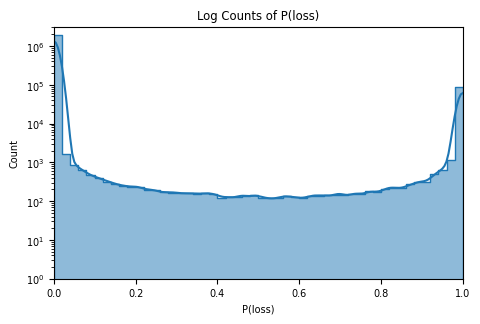

In [17]:
fig, ax = plt.subplots()
g = sns.histplot(
    p_loss,
    x="p_loss",
    element="step",
    common_norm=False,
    stat="count",
    kde=True,
    bins=50,
    ax=ax,
    log_scale=(False, True)
)
ax.set_xlim(0, 1)
ax.set_ylim(1, 3_000_000)
ax.set_xlabel("P(loss)")
plt.title("Log Counts of P(loss)")
plt.savefig(figure_path/"ZeDiAc_p_loss_hist.pgf", bbox_inches="tight")
plt.savefig(figure_path/"ZeDiAc_p_loss_hist.png", bbox_inches="tight")

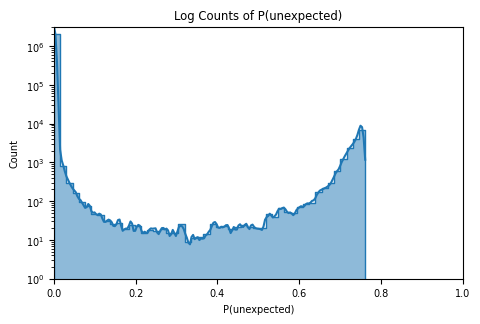

In [18]:
fig, ax = plt.subplots()
g = sns.histplot(
    p_unexpected,
    x="p_unexpected",
    element="step",
    common_norm=False,
    stat="count",
    kde=True,
    bins=50,
    ax=ax,
    log_scale=(False, True)
)
ax.set_xlim(0, 1)
ax.set_ylim(1, 3_000_000)
ax.set_xlabel("P(unexpected)")
plt.title("Log Counts of P(unexpected)")
plt.savefig(figure_path/"ZeDiAc_p_unexpected_hist.pgf", bbox_inches="tight")
plt.savefig(figure_path/"ZeDiAc_p_unexpected_hist.png", bbox_inches="tight")

In [3]:
def create_sliding_window_sentence_chunks(sentences, chunk_size):
    chunks = []
    chunk_id = []
    for i in range(len(sentences)-chunk_size+1):
        chunks.append(" ".join(sentences[i:i+chunk_size]))
        chunk_id.append(f"{chunk_size}_{i}")
    return {"chunk": chunks, "chunk_id": chunk_id}

def create_sentence_chunks(text, max_chunk_size=5):
    sentences = sent_tokenize(text)
    result = {"text": [], "chunk_id": []}
    for chunk_size in range(1, max_chunk_size+1):
        chunks = create_sliding_window_sentence_chunks(sentences, chunk_size)
        result["text"].extend(chunks["chunk"])
        result["chunk_id"].extend(chunks["chunk_id"])
    return result

In [4]:
def get_chunking_structure_dict(list_of_chunks, list_of_chunk_indices, list_of_classifications):
    structure = {}
    levels = []
    for index in list_of_chunk_indices:
        levels.append(int(index.split("_")[0]))
    levels.sort()
    levels = set(levels)
    structure["min_level"] = min(levels)
    structure["max_level"] = max(levels)
    for level in levels:
        structure[level] = {"indices": [],
                            "classifications": [],
                            "chunks": [],
                            "min_index": 0,
                            "max_index": 0}
    for index, classification, chunk in zip(list_of_chunk_indices, list_of_classifications, list_of_chunks):
        l, i = index.split("_")
        l, i = int(l), int(i)
        structure[l]["indices"].append(i)
        structure[l]["classifications"].append(classification)
        structure[l]["chunks"].append(chunk)
        if structure[l]["max_index"] < i:
            structure[l]["max_index"] = i
    return structure

In [5]:
def combine_chunks_of_level(structure, level):
    structure = structure[level].copy()
    prev = False
    current_chunk = ""
    combined_chunks = []
    for index in range(structure["min_index"], structure["max_index"] +1):
        i = structure["indices"].index(index)
        if structure["classifications"][i]:
            if prev:
                current_sentences = sent_tokenize(structure["chunks"][i])
                current_chunk += " " + current_sentences[level-1]
            elif len(current_chunk) > 0:
                combined_chunks.append(current_chunk)
                current_chunk = structure["chunks"][i]
                prev = True
            else:
                current_chunk = structure["chunks"][i]
                prev = True
        else:
            prev = False
    if len(current_chunk) > 0:
        combined_chunks.append(current_chunk)
    return combined_chunks

def get_shortest_chunks(list_of_chunks, list_of_chunk_indices, list_of_classifications):
    structure = get_chunking_structure_dict(list_of_chunks, list_of_chunk_indices, list_of_classifications)
    for level in range(structure["min_level"], structure["max_level"]+1):
        combined_chunks = combine_chunks_of_level(structure, level)
        if len(combined_chunks) > 0:
            return combined_chunks
    return []

In [6]:
df = pd.read_pickle(base_path/"data/predictions/data_chunks.pkl")
df.shape[0]

78022

In [8]:
df["loss"] = df.p_loss > 0.5
df["unexpected"] = df.p_unexpected > 0.5
df["ul"] = df.apply(lambda x: True if x["loss"] and x["unexpected"] else False, axis=1)

In [9]:
df_chunks = df.groupby(by=["report_id", "paragraph_nr"], as_index=True).apply(lambda x: get_shortest_chunks( x["text"], x["chunk_nr"], x["ul"] )).to_frame().rename(columns={0: 'chunks'})
df_chunks["n_chunks"] = df_chunks["chunks"].apply(lambda x: len(x))
df_chunks = df_chunks[df_chunks.n_chunks > 0]
df_chunks = df_chunks.explode("chunks")
df_chunks["n_sentences"] = df_chunks["chunks"].apply(lambda x: len(sent_tokenize(x)))
df_chunks["n_words"] = df_chunks["chunks"].apply(lambda x: len(word_tokenize(x)))

In [10]:
df_chunks.shape[0]

6126

In [12]:
df_chunks.to_csv(base_path/"data/predictions/Chunks.csv", index=False)

Text(0.5, 0, 'Number of words per chunk')

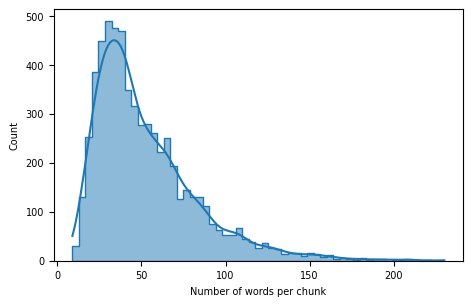

In [13]:
fig, ax = plt.subplots()
g = sns.histplot(
   df_chunks,
    x="n_words",
    element="step",
    common_norm=False,
    kde=True,
    ax=ax
)
ax.set_xlabel("Number of words per chunk")
plt.savefig(figure_path/"chunks_positive_n_words_hist.pgf", bbox_inches="tight")
plt.savefig(figure_path/"chunks_positive_n_words_hist.pgf", bbox_inches="tight")

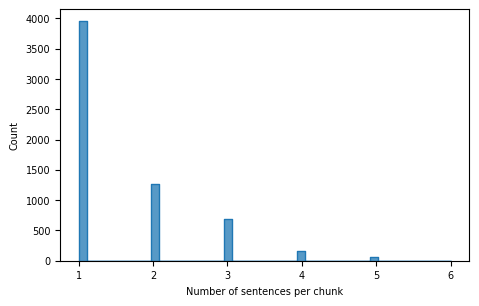

In [17]:
fig, ax = plt.subplots()
g = sns.histplot(
   df_chunks,
    x="n_sentences",
    element="step",
    common_norm=False,
    #kde=True,
    ax=ax
)
ax.set_xlabel("Number of sentences per chunk")
plt.savefig(figure_path/"chunks_positive_n_sentences_hist.pgf", bbox_inches="tight")
plt.savefig(figure_path/"chunks_positive_n_sentences_hist.pgf", bbox_inches="tight")